In [5]:
%matplotlib inline


# Enhanced chroma and chroma variants


This notebook demonstrates a variety of techniques for enhancing chroma features and 
also, introduces chroma variants implemented in librosa.



Enhanced chroma
^^^^^^^^^^^^^^^
Beyond the default parameter settings of librosa's chroma functions, we apply the following 
enhancements:

   1. Over-sampling the frequency axis to reduce sensitivity to tuning deviations
   2. Harmonic-percussive-residual source separation to eliminate transients.
   3. Nearest-neighbor smoothing to eliminate passing tones and sparse noise.  This is inspired by the
      recurrence-based smoothing technique of
      `Cho and Bello, 2011 <http://ismir2011.ismir.net/papers/OS8-4.pdf>`_.
   4. Local median filtering to suppress remaining discontinuities.



In [6]:
# Code source: Brian McFee
# License: ISC
# sphinx_gallery_thumbnail_number = 6

from __future__ import print_function
import numpy as np
import scipy
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [7]:
filename = librosa.util.example_audio_file()

We'll use a track that has harmonic, melodic, and percussive elements



In [8]:
y, sr = librosa.load(filename)

First, let's plot the original chroma



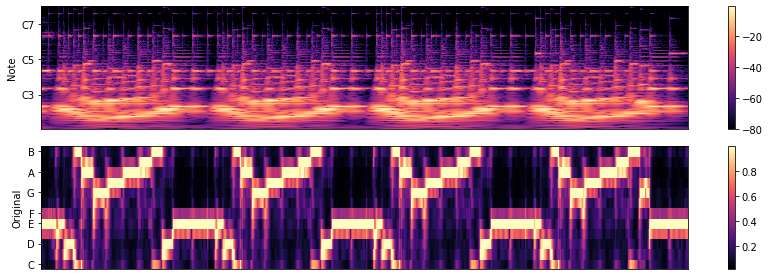

In [9]:
chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr)

# For display purposes, let's zoom in on a 15-second chunk from the middle of the song
idx = tuple([slice(None), slice(*list(librosa.time_to_frames([45, 60])))])

# And for comparison, we'll show the CQT matrix as well.
C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3))


plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max)[idx],
                         y_axis='cqt_note', bins_per_octave=12*3)
plt.colorbar()
plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Original')
plt.tight_layout()

We can correct for minor tuning deviations by using 3 CQT
bins per semi-tone, instead of one



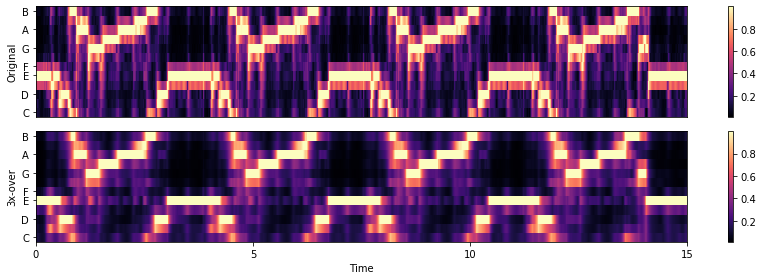

In [10]:
chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Original')


plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_os[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('3x-over')
plt.tight_layout()

That cleaned up some rough edges, but we can do better
by isolating the harmonic component.
We'll use a large margin for separating harmonics from percussives



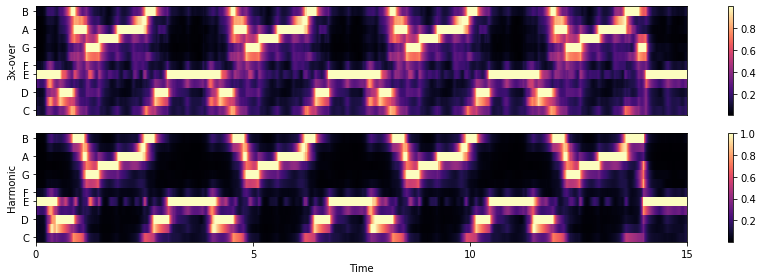

In [11]:
y_harm = librosa.effects.harmonic(y=y, margin=8)
chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_os[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('3x-over')

plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_os_harm[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Harmonic')
plt.tight_layout()

There's still some noise in there though.
We can clean it up using non-local filtering.
This effectively removes any sparse additive noise from the features.



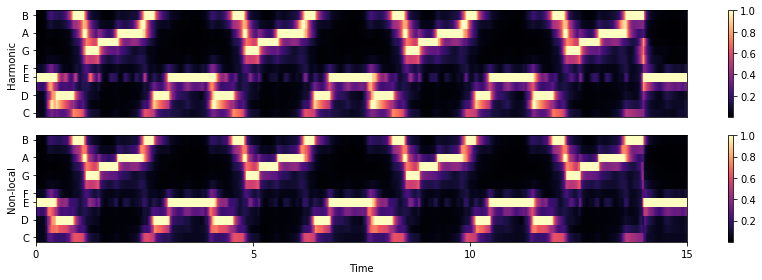

In [12]:
chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm,
                                                       aggregate=np.median,
                                                       metric='cosine'))


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_os_harm[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Harmonic')

plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_filter[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Non-local')
plt.tight_layout()

Local discontinuities and transients can be suppressed by
using a horizontal median filter.



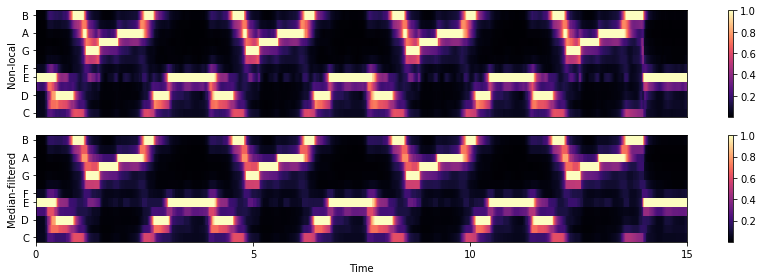

In [13]:
chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_filter[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Non-local')

plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_smooth[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Median-filtered')
plt.tight_layout()

A final comparison between the CQT, original chromagram
and the result of our filtering.



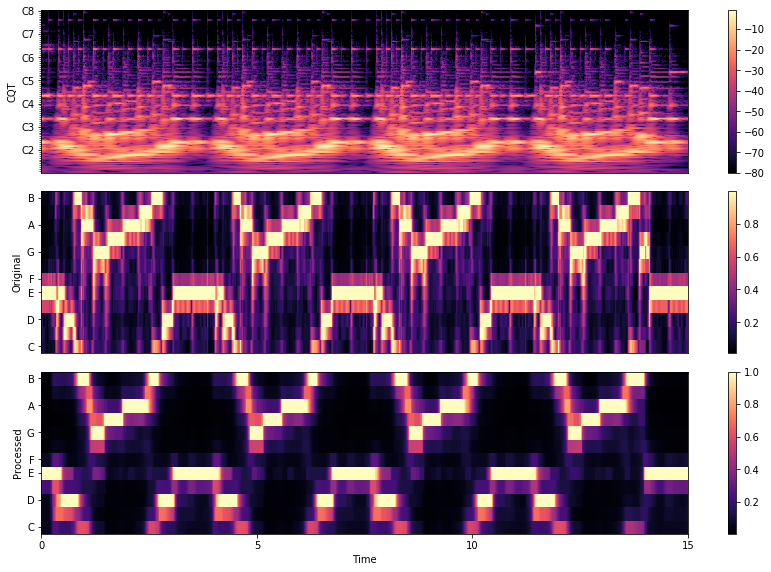

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max)[idx],
                         y_axis='cqt_note', bins_per_octave=12*3)
plt.colorbar()
plt.ylabel('CQT')
plt.subplot(3, 1, 2)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.ylabel('Original')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(chroma_smooth[idx], y_axis='chroma', x_axis='time')
plt.ylabel('Processed')
plt.colorbar()
plt.tight_layout()
plt.show()

Chroma variants
^^^^^^^^^^^^^^^
There are three chroma variants implemented in librosa: `chroma_stft`, `chroma_cqt`, and `chroma_cens`.
`chroma_stft` and `chroma_cqt` are two alternative ways of plotting chroma.    

`chroma_stft` performs short-time fourier transform of an audio input and maps each STFT bin to chroma, while `chroma_cqt` uses constant-Q transform and maps each cq-bin to chroma.      

A comparison between the STFT and the CQT methods for chromagram. 



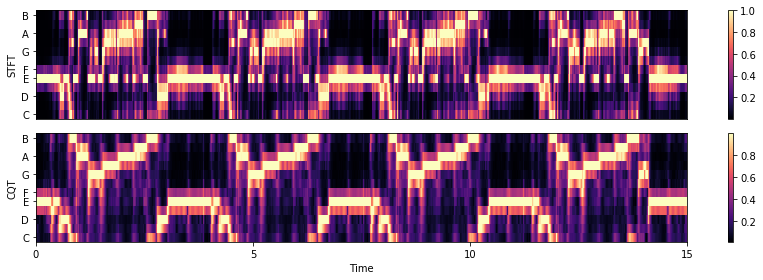

In [15]:
chromagram_stft = librosa.feature.chroma_stft(y=y, sr=sr)
chromagram_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chromagram_stft[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('STFT')

plt.subplot(2, 1, 2)
librosa.display.specshow(chromagram_cqt[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('CQT')
plt.tight_layout()

CENS features (`chroma_cens`) are variants of chroma features introduced in 
`Müller and Ewart, 2011 <http://ismir2011.ismir.net/papers/PS2-8.pdf>`_, in which 
additional post processing steps are performed on the constant-Q chromagram to obtain features 
that are invariant to dynamics and timbre.     

Thus, the CENS features are useful for applications, such as audio matching and retrieval.

Following steps are additional processing done on the chromagram, and are implemented in `chroma_cens`:  
  1. L1-Normalization across each chroma vector
  2. Quantization of the amplitudes based on "log-like" amplitude thresholds
  3. Smoothing with sliding window (optional parameter) 
  4. Downsampling (not implemented)

A comparison between the original constant-Q chromagram and the CENS features.  



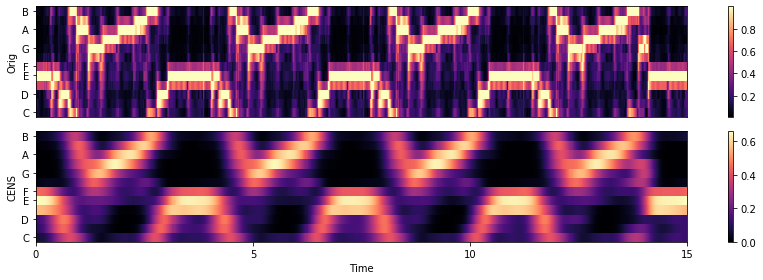

In [16]:
chromagram_cens = librosa.feature.chroma_cens(y=y, sr=sr)


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chromagram_cqt[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Orig')

plt.subplot(2, 1, 2)
librosa.display.specshow(chromagram_cens[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('CENS')
plt.tight_layout()